In [3]:
from jax.config import config
config.update("jax_debug_nans", True)

from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np

from src.lib_phaseshifts import readPHASESHIFTS
from src.lib_tensors import *
from src.lib_delta import *
from src.delta import *

In [4]:
#From "PARAM"
LMAX = 14  # maximum angular momentum to be used in calculation
n_beams = 9  # no. of TLEED output beams
n_atoms = 1  # currently 1 is the only possible choice
n_geo = 1  # number of geometric variations ('displacements') to be considered

# From Stdin
# DR0,DRPER,DRPAR: thermal vibration amplitude steps to be included in
# current variation - DR0 is always 0., DRPER = DRPAR forced
DR0 = 0
DRPER = 0.1908624
DRPAR = DRPER

CDISP = np.full((n_geo, n_atoms, 3),dtype=np.float64,fill_value=np.nan)  # displaced positions of current atomic site for variation
for i in range(n_geo):
    CDISP[i][0][0] = -0.01*i + 0.05
    CDISP[i][0][1] = 0
    CDISP[i][0][2] = 0
print(CDISP)


[[[0.05 0.   0.  ]]]


In [5]:
# unit vectors in Angstrom
u_vec1 = np.array([1.2722, -2.2036])
u_vec2 = np.array([1.2722,  2.2036])

# area of (overlayer) lateral unit cell - in case TLEED wrt smaller unit cell is used, TVA from reference computation must be set.
unit_cell_area = np.linalg.norm(np.cross(u_vec1, u_vec2))
# In Bohr radii
unit_cell_area = unit_cell_area / BOHR**2

In [6]:
IEL = 1  # element no. (in phase shifts supplied with input) that delta amplitudes
#          will be calculated for (not necessarily the same element as the one
#          used in the reference calculation!) - IEL = 0 means a vacancy will be assumed

In [7]:
phaseshifts_file = Path("PHASESHIFTS")
T1_file = Path("T_1")

In [8]:
_, phaseshifts, _, _ = readPHASESHIFTS(None, None, readfile=phaseshifts_file,
                                       check=False, ignoreEnRange=False)


PHASESHIFTS file not found.


FileNotFoundError: [Errno 2] No such file or directory: 'PHASESHIFTS'

In [9]:
n_energies = 0
with open(T1_file, 'r') as datei:
    for zeile in datei:
        if '-1' in zeile:
            n_energies += 1


FileNotFoundError: [Errno 2] No such file or directory: 'T_1'

In [10]:
tensor_dict = read_tensor(T1_file, n_beams=9, n_energies= n_energies, l_max=LMAX+1)

# TODO: raise Error if requested energies are out of range respective to
# phaseshift energies (can't interpolate if out of range)

#n_energies = 51
energies = np.array([tensor_dict['e_kin'][i] for i in range(n_energies)])
interpolated_phaseshifts = interpolate_phaseshifts(phaseshifts, LMAX, energies)

all_delwv = np.full((n_energies, n_geo, n_beams), dtype=np.complex128, fill_value=np.nan)
for nc, displacement in enumerate(CDISP):

    d_amplitude = delta_amplitude(tensor_dict, interpolated_phaseshifts, displacement)
    all_delwv[:, nc, :] = d_amplitude


RuntimeError: Unable to read Tensor file: T_1

In [11]:
e_inside = tensor_dict['e_kin']  # computational energy inside crystal
t_matrix_ref = tensor_dict['t_matrix']  # atomic t-matrix of current site as used in reference calculation
VV = tensor_dict['v0r']  # real part of the inner potential
v_imag = tensor_dict['v0i_substrate']# imaginary part of the inner potential, substrate

tensor_amps_out = tensor_dict['tensor_amps_out']  # spherical wave amplitudes incident from exit beam NEXIT in "time-reversed"
#                                       LEED experiment (or rather, all terms of Born series immediately after
#                                       scattering on current atom)
tensor_amps_in = tensor_dict['tensor_amps_in']  # spherical wave amplitudes incident on current atomic site in reference calculation
# crop tensors to LMAX
tensor_amps_out = tensor_amps_out[:, :(LMAX+1)**2, :]
tensor_amps_in = tensor_amps_in[:, :(LMAX+1)**2] 
#                                     (i.e., scattering path ends before scattering on that atom)
out_k_par2, out_k_par3 = tensor_dict['kx_in'], tensor_dict['ky_in']  # (negative) absolute lateral momentum of Tensor LEED beams
#                                                        (for use as incident beams in time-reversed LEED calculation)

# NewCAF: working array in which current (displaced) atomic t-matrix is stored
# TODO: we could also either append empty phaseshifts to the phaseshifts array or move the conditional around tscatf
selected_phaseshifts = _select_phaseshifts(IEL, interpolated_phaseshifts)
tscatf_vmap = jax.vmap(tscatf, in_axes=(None, None, 0, 0, None, None, None, None))
t_matrix_new = tscatf_vmap(IEL, LMAX,
                            selected_phaseshifts,
                            e_inside, DR0, DRPER, DRPAR)

# amplitude differences
matel_dwg_vmap_energy = jax.vmap(MATEL_DWG, in_axes=(0, 0, 0, 0, None, 0, 0, 0, 0, None, None))
d_amplitude = matel_dwg_vmap_energy(t_matrix_ref, t_matrix_new, e_inside, v_imag,
                    LMAX, tensor_amps_out, tensor_amps_in, out_k_par2, out_k_par3,
                    unit_cell_area, displacement)


NameError: name 'tensor_dict' is not defined

In [12]:
matel_dwg_vmap_energy = jax.vmap(MATEL_DWG, in_axes=(0, 0, 0, 0, None, 0, 0, 0, 0, None, None))
matel_q = lambda d: matel_dwg_vmap_energy(t_matrix_ref, t_matrix_new, e_inside, v_imag,
                    LMAX, tensor_amps_out, tensor_amps_in, out_k_par2, out_k_par3,
                    unit_cell_area, d)


NameError: name 'MATEL_DWG' is not defined

In [13]:
matel_jac = jax.jacfwd(matel_dwg_vmap_energy, argnums=10)
matel_j = lambda d: matel_jac(t_matrix_ref, t_matrix_new, e_inside, v_imag,
                    LMAX, tensor_amps_out, tensor_amps_in, out_k_par2, out_k_par3,
                    unit_cell_area, d)

NameError: name 'matel_dwg_vmap_energy' is not defined

In [14]:
harm = lambda d: HARMONY(d, LMAX)
harm_jac = lambda d: jax.jacfwd(HARMONY, argnums=0)(d, LMAX)

In [15]:
# TESTING

fun = []
jac = []
ha_fun = []

r = jnp.arange(-0.01, 0.01, 0.001)

for z in r:
    d = jnp.array([[z, 0, 0],])
    fun.append(matel_q(d))
    jac.append(matel_j(d))
    ha_fun.append(harm(d[0]))


NameError: name 'matel_q' is not defined

In [16]:
res = []
for e in range(500):
    res.append(matel_q(jnp.array([[10**(-(e+6)/100),0,0],])).sum())
plt.plot(res, 'o')

NameError: name 'matel_q' is not defined

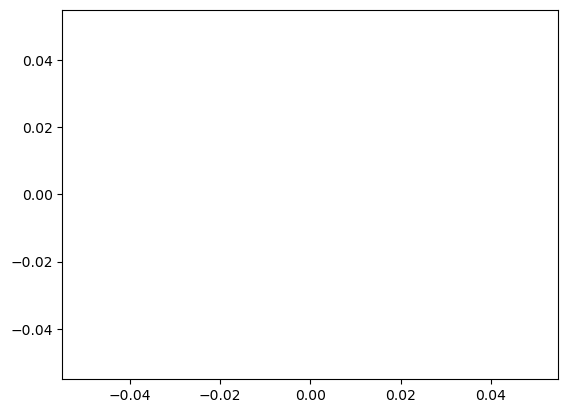

In [17]:
plt.figure()
plt.plot([h.real for h in ha_fun], ls='-', marker='o')

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

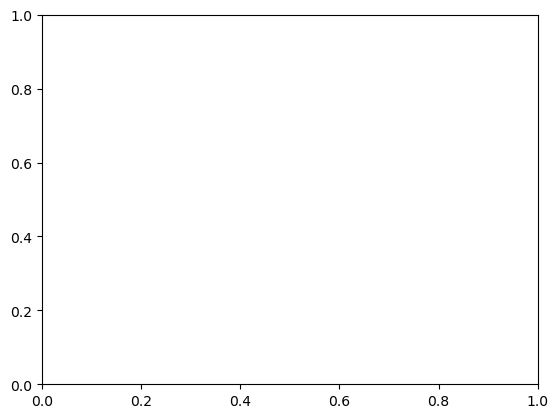

In [18]:
plt.figure()
plt.plot(r, [abs(f.sum()) for f in fun], ls='-', marker='o')

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

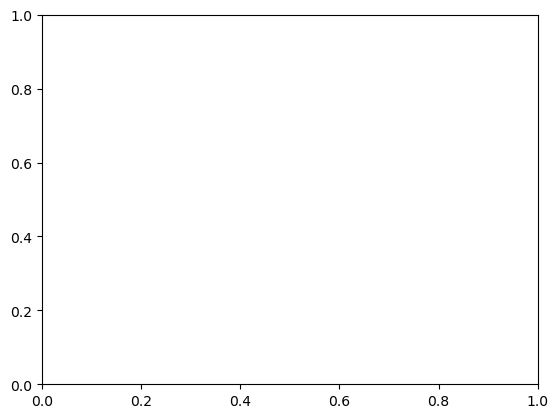

In [19]:
plt.figure()
plt.plot(r,[abs(j[0,0,0][0]) for j in jac], ls='-', marker='o')

In [20]:
C = np.array([0.0041, 0.000, 0.0000])
r = jnp.linalg.norm(C)

In [21]:
jnp.arctan2(C[2], C[1]), jnp.arctan2(C[2], C[1]+EPS)

(Array(0., dtype=float64), Array(0., dtype=float64))

In [22]:
from matplotlib import pyplot as plt

In [23]:
from matplotlib import pyplot as plt

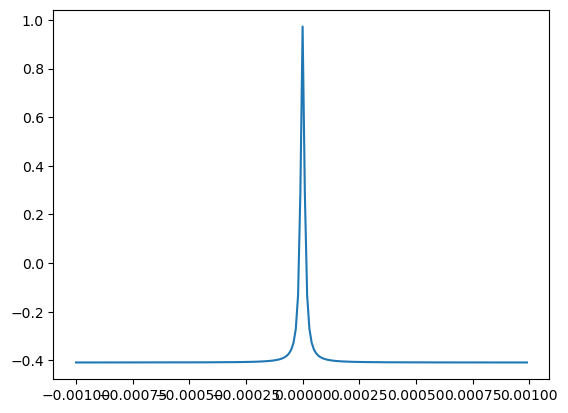

In [56]:
arr = jnp.arange(-0.001, 0.001, 0.00001)
res = []
for z in arr:
    res.append(np.sum(HARMONY(jnp.array([0, z, 0.00001]), 1).real))
plt.plot(arr, res)


In [58]:
scipy.special.sph_harm(0, 0, 0.0, 0)

(0.28209479177387814+0j)

/var/folders/fv/bxt6sbpd2sn0kbhr1rksclxc0000gp/T/ipykernel_49736/3330153866.py:4: RuntimeWarning: invalid value encountered in arccos
  res.append(np.arccos(z+1))


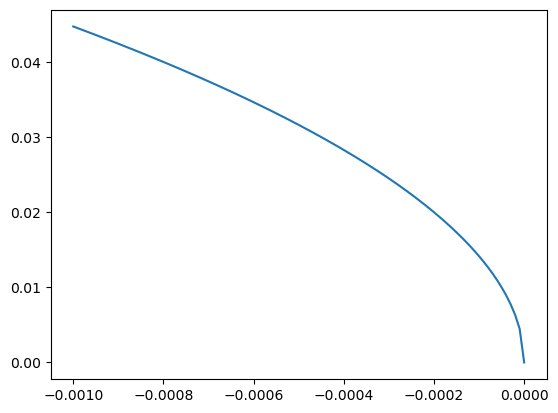

In [61]:
arr = jnp.arange(-0.001, 0.001, 0.00001)
res = []
for z in arr:
    res.append(np.arccos(z+1))
plt.plot(arr, res)

In [118]:
def to_polar(c):
    z, x, y = c
    theta = np.arctan2(np.sqrt(x**2 + y**2), z)
    phi = np.arctan2(y, x)
    r = np.linalg.norm(c)
    return r, theta, phi


In [111]:
def cart_to_polar(c):
    """Converts cartesian coordinates to polar coordinates."""
    r = safe_norm(c)
    eps_sign_z = EPS*jnp.sign(c[0])
    theta = jnp.arccos(_divide_zero_safe(c[0], r, 1.0)-eps_sign_z)
    # Alternative implementation to avoid division by zero:
    # theta = jnp.arccos((C[0]+eps_sign_z)/(r+EPS)-eps_sign_z)
    phi = jnp.arctan2(c[2]+EPS, c[1]+EPS)
    return r, theta, phi


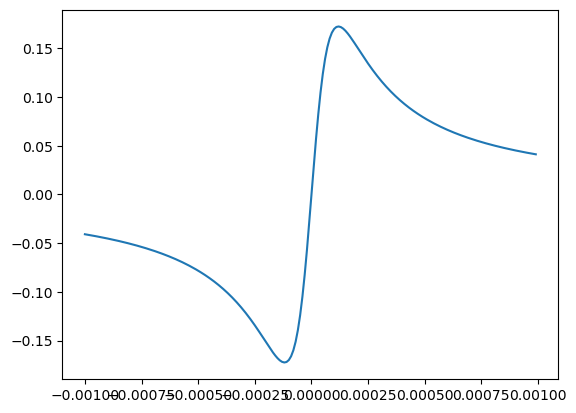

In [131]:
arr = jnp.arange(-0.001, 0.001, 0.00001)
res = []
res_orig = []
res_better = []
for z in arr:
    x_y_z = (z, 0.0001, 0.0)
    res_orig.append(cart_to_polar(np.array(x_y_z)))
    res_better.append(to_polar(np.array(x_y_z)))
    res.append(res_orig[-1][1] - res_better[-1][1])
plt.plot(arr, res)




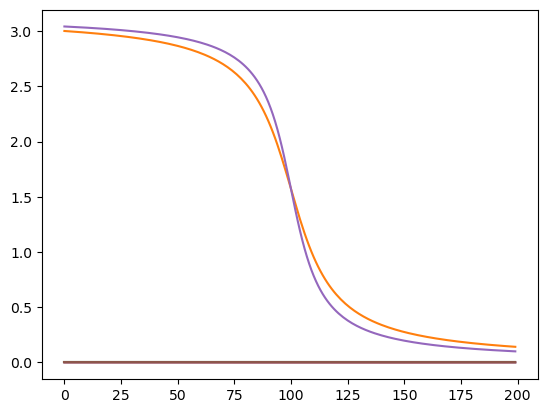

In [133]:
plt.plot(res_orig)
plt.plot(res_better)

In [114]:
HARMONY(np.array([0.01, 0.0, 0.0]), 1)

Array([ 2.82094792e-01+0.j        ,  2.44313471e-03-0.00244313j,
        4.88578079e-01+0.j        , -2.44313471e-03-0.00244313j,
       -2.11564730e-19+0.00345511j,  2.44313471e-03-0.00244313j,
        4.88578079e-01+0.j        , -2.44313471e-03-0.00244313j,
       -2.11564730e-19-0.00345511j], dtype=complex128)

In [115]:
def _divide_zero_safe(
    numerator: jnp.ndarray,
    denominator: jnp.ndarray,
    limit_value: float = 0.0,
) -> jnp.ndarray:
    """Function that forces the result of dividing by 0 to be equal to a limit
    value in a jit- and autodiff-compatible way

    Args:
        numerator: Values in the numerator
        denominator: Values in the denominator, may contain zeros
        limit_value: Value to return where denominator == 0.0
    Returns:
        numerator / denominator with result == 0.0 where denominator == 0.0
    """
    denominator_masked = jnp.where(denominator == 0.0, 1.0, denominator)
    return jnp.where(
        denominator == 0.0,
        limit_value,
        numerator / denominator_masked,
    )

def test(C):
    r = safe_norm(C)
    eps_sign_z = EPS*jnp.sign(C[0])
    a = jnp.arccos(_divide_zero_safe(C[0], r, 1.0)-eps_sign_z)
    b = jnp.arccos((C[0]+eps_sign_z)/(r+EPS)-eps_sign_z)
    return a, b

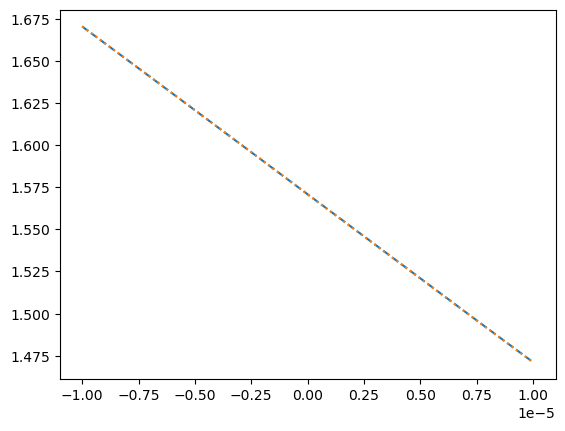

In [43]:
arr = jnp.arange(-0.00001, 0.00001, 0.0000001)
res_a = []
res_b = []
res = []
for z in arr:
    a,b = test(jnp.array([z, 0.000, 0.0]))
    res_a.append(a)
    res_b.append(b)
    res.append(a-b)

plt.plot(arr, res_a, '--')
plt.plot(arr, res_b, ':')


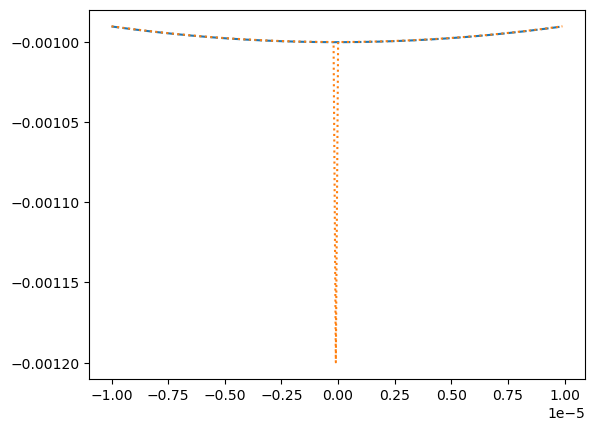

In [46]:
plt.plot(arr[:-1], np.diff(res_a), '--')
plt.plot(arr[:-1], np.diff(res_b), ':')

In [25]:
HARMONY(jnp.array([0, 0.000, 0.0]), 14)

Array([ 2.82094792e-01+0.00000000e+00j,  2.44301256e-01-2.44301256e-01j,
        2.99182751e-17+0.00000000e+00j, -2.44301256e-01-2.44301256e-01j,
        2.36524733e-17-3.86274202e-01j,  3.34496485e-17-3.34496485e-17j,
       -3.15391565e-01-0.00000000e+00j, -3.34496485e-17-3.34496485e-17j,
        2.36524733e-17+3.86274202e-01j, -2.95021795e-01-2.95021795e-01j,
        3.83183179e-33-6.25785621e-17j, -2.28522900e-01+2.28522900e-01j,
       -6.85513802e-17-0.00000000e+00j,  2.28522900e-01+2.28522900e-01j,
        3.83183179e-33+6.25785621e-17j,  2.95021795e-01-2.95021795e-01j,
       -4.42532692e-01-5.41946245e-17j, -5.41946245e-17-5.41946245e-17j,
       -2.04836427e-17+3.34523272e-01j, -6.14509281e-17+6.14509281e-17j,
        3.17356641e-01+0.00000000e+00j,  6.14509281e-17+6.14509281e-17j,
       -2.04836427e-17-3.34523272e-01j,  5.41946245e-17-5.41946245e-17j,
       -4.42532692e-01+5.41946245e-17j, -3.28191028e-01+3.28191028e-01j,
       -8.98716176e-17-1.10060989e-32j,  2.44619150

In [ ]:
def theta(c):
    return jnp.arccos(_divide_zero_safe(c[0], jnp.linalg.norm(c), 1.0)-EPS*jnp.sign(c[0]))

In [ ]:
def theta(c):
    return jnp.arccos((c[0]+EPS*jnp.sign(c[0]))/(jnp.linalg.norm(c)+EPS)-EPS*jnp.sign(c[0]))

In [ ]:
from src.lib_math import _divide_zero_safe
jax.grad(_divide_zero_safe)(0.1, 0.1, 1.0), _divide_zero_safe(0.1, 0.1, 1.0)

(Array(10., dtype=float64, weak_type=True),
 Array(1., dtype=float64, weak_type=True))

In [ ]:
arr = jnp.linspace(-0.001+EPS, 0.001-EPS, 3000)

In [ ]:
f1 = lambda x: theta(jnp.array([x, 0.000, 0.]))
f2 = lambda x: jax.grad(theta)(jnp.array([x, 0.000, 0.]))

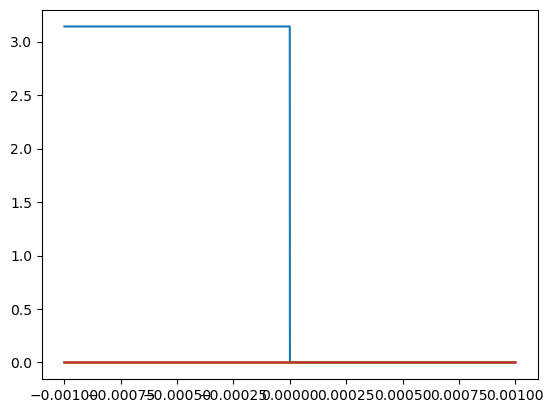

In [ ]:
plt.figure()
plt.cla()
plt.plot(arr, [f1(a) for a in arr])
plt.plot(arr, jax.vmap(f2)(arr))

In [ ]:
x = 1e-10
jax.jit(f1).lower(x).cost_analysis()['flops'], jax.jit(f2).lower(x).cost_analysis()['flops']

(19.0, 40.0)

In [ ]:
jax.vmap(f2)(arr)

Array([[-8.16496586e-05,  0.00000000e+00,  0.00000000e+00],
       [-8.17404898e-05,  0.00000000e+00,  0.00000000e+00],
       [-8.18314793e-05,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 9.09494702e-13,  0.00000000e+00,  0.00000000e+00],
       [-9.09494702e-13,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],      dtype=float64)

In [ ]:
f3 = jnp.arctan2
f4 = jax.grad(f4)

NameError: name 'f4' is not defined

In [ ]:
plt.figure()
plt.plot(arr, f3(arr,arr))
#plt.plot(arr, jax.vmap(f4)(arr))

In [ ]:
# Bessel
bessel(1e-20+1e-20j, 10)

Array([ 5.00000000e-01-5.00000000e-001j, -5.00000000e+19+0.00000000e+000j,
       -1.00000000e-01-1.00000000e-001j,  0.00000000e+00-2.85714286e-022j,
        3.17460317e-43-3.17460317e-043j,  5.77200577e-64-5.92000592e-106j,
        0.00000000e+00+0.00000000e+000j,  0.00000000e+00+0.00000000e+000j,
                   nan            +nanj,             nan            +nanj],      dtype=complex128)

In [ ]:
config.update("jax_debug_nans", False)
print(bessel(0,10))
config.update("jax_debug_nans", True)

[ 1. nan nan nan nan nan nan nan nan nan]


In [ ]:
config.update("jax_debug_nans", False)